In [50]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
np.set_printoptions(suppress=True)

import autograd.numpy as anp
from autograd import hessian, grad
from autograd import grad as grad_a

import jax
import jax.numpy as jnp
from jax import jit
from jax import grad as grad_j

In [3]:
N = 100

a, b, m = 0.1, 0.02, 2.5 # parameters for the failure rate function

def failure_probability(d, x):
    """
    Calculate the probability of failure based on the current degradation level and an increment in degradation level.

    Args:
        d (float): Current degradation level
        x (float): Increment in degradation level
        max_degradation (float): Maximum degradation level

    Returns:
        p: Probability of failure
    """
    return 1 - np.exp(
        -(
            a*x + b*x*(3*m**2 - 3*m*(x+2*d) + x**2 + 3*x*d + 3*d**2)/3   
        )
    )

def log_likelihood(theta, X, Z, y):
    """
    Calculate the log-likelihood of the model given the parameters and data.

    Args:
        theta (np.ndarray): Model parameters
        X (np.ndarray): Current observed contexts
        Z (np.ndarray): Cumulative observed contexts
        y (np.ndarray): Failure outcome

    Returns:
        log_likelihood: Log-likelihood value
    """
    p = failure_probability(Z @ theta.T, X @ theta.T).flatten()
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

def failure_probability_anp(d, x):
    return 1 - anp.exp(-(
        a * x + b * x * (3 * m**2 - 3 * m * (x + 2 * d) + x**2 + 3 * x * d + 3 * d**2) / 3
    ))

def log_likelihood_anp(theta, X, Z, y):
    theta = theta.reshape(-1, 1)
    d = anp.dot(Z, theta)  # (n, 1)
    x = anp.dot(X, theta)  # (n, 1)
    p = failure_probability_anp(d, x).flatten()
    p = anp.clip(p, 1e-8, 1 - 1e-8)  # avoid log(0)
    return anp.sum(y * anp.log(p) + (1 - y) * anp.log(1 - p))

def compute_hessian_and_se(theta_hat, X, Z, y):
    hess_fn = hessian(log_likelihood_anp)
    H = hess_fn(theta_hat, X, Z, y)
    cov = -np.linalg.inv(H)  # negative because log-likelihood is maximized, not minimized
    std_errors = np.sqrt(np.diag(cov))
    return H, cov, std_errors

def get_random_increment_x():
    """
    Sample a random increment x from a discrete uniform distribution.

    Returns:
        x: Random increment
    """
    return np.random.randint(N) / N

def simulate_machine(theta, d):
    usage = np.zeros(d)
    time_until_failure = 0
    contexts = np.zeros((0, d))
    
    while True:
        x = np.random.uniform(0, 1, size=d)
        contexts = np.vstack((contexts, x))
        
        current_degradation = theta @ usage
        additional_degradation = theta @ x
        p = np.random.random()
        if p <= failure_probability(current_degradation, additional_degradation):
            # machine failure
            return contexts
        usage += x
        time_until_failure += 1


Create a sample trajectory and see its log-likelihood and Fisher information

In [96]:
d = 15
theta = np.random.uniform(0, 1, size=(1,d))
contexts = simulate_machine(theta=theta, d=d)
cumulative_contexts = np.cumsum(contexts, axis=0)
cumulative_contexts = np.vstack((np.zeros(d), cumulative_contexts[:-1]))
y = np.zeros(len(contexts))
y[-1] = 1

In [97]:
avg_log_likelihood = log_likelihood(theta=theta, X=contexts, Z=cumulative_contexts, y=y) / len(contexts)
H, cov, std_errs = compute_hessian_and_se(theta.flatten(), X=contexts, Z=cumulative_contexts, y=y)

/var/folders/k0/fk1yjsp11fg_7yjml4xg3kmc0000gn/T/ipykernel_79551/558438223.py:56: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(np.diag(cov))


In [98]:
avg_log_likelihood, std_errs

(-0.6367192445001768,
 array([            nan,  1.22360357e+17,             nan,  8.24664329e+16,
                    nan,             nan,             nan,  1.81638045e+17,
         4.70490094e+09,             nan,  2.68229065e+09, -0.00000000e+00,
         3.09454797e+17,             nan,  2.82251285e+17]))

In [99]:
X, Z, y = np.zeros((0, d)), np.zeros((0, d)), np.zeros(0)

for i in range(500):
    contexts = simulate_machine(theta=theta, d=d)
    cumulative_contexts = np.cumsum(contexts, axis=0)
    cumulative_contexts = np.vstack((np.zeros(d), cumulative_contexts[:-1]))
    
    X = np.vstack((X, contexts))
    Z = np.vstack((Z, cumulative_contexts))
    y_temp = np.zeros(contexts.shape[0])
    y_temp[-1] = 1
    y = np.concatenate((y, y_temp))

In [100]:
theta

array([[0.59131553, 0.60951556, 0.89197034, 0.98020172, 0.34501594,
        0.18477516, 0.82445028, 0.67304943, 0.49415291, 0.73250509,
        0.89123581, 0.74942051, 0.06764342, 0.97528009, 0.7120251 ]])

In [101]:
avg_log_likelihood = log_likelihood_anp(theta=theta, X=X, Z=Z, y=y) / len(X)
H, cov, std_errs = compute_hessian_and_se(theta.flatten(), X=X, Z=Z, y=y)
avg_log_likelihood, std_errs

(-0.5392286997935356,
 array([0.47462341, 0.47137324, 0.44511635, 0.44968223, 0.44556066,
        0.44814241, 0.47620086, 0.48811033, 0.43361021, 0.48218269,
        0.47923732, 0.45667863, 0.42682661, 0.45226198, 0.46482922]))

In [102]:
fake_theta = 1-theta
avg_log_likelihood = log_likelihood_anp(theta=fake_theta, X=X, Z=Z, y=y) / len(X)
H, cov, std_errs = compute_hessian_and_se(fake_theta.flatten(), X=X, Z=Z, y=y)
avg_log_likelihood, std_errs

(-0.8548291027373381,
 array([0.50355889, 0.4706071 , 0.53950426, 0.48087311, 0.4698978 ,
        0.50224862, 0.58432243, 0.46386875, 0.48673497, 0.46380227,
        0.47102247, 0.45985276, 0.43587186, 0.47706726, 0.51184732]))

In [103]:
grad_fn = grad_a(log_likelihood_anp)

def gradient_ascent_autograd(theta_init, X, Z, y, batch_size=5, learning_rate=0.01, num_epochs=10):
    """
    Perform mini-batch gradient ascent over multiple epochs using autograd.

    Each epoch shuffles the full dataset and processes it in mini-batches.
    Logs log-likelihood at the end of each epoch.
    """
    theta = theta_init.copy()
    n = X.shape[0]
    
    for epoch in trange(num_epochs):
        indices = np.random.permutation(n)
        X_shuffled = X[indices]
        Z_shuffled = Z[indices]
        y_shuffled = y[indices]

        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_shuffled[start:end]
            batch_Z = Z_shuffled[start:end]
            batch_y = y_shuffled[start:end]

            gradient = grad_fn(theta, batch_X, batch_Z, batch_y)
            # gradient ascent (maximizing log-likelihood)
            theta += learning_rate * gradient

        ll = log_likelihood_anp(theta, X, Z, y) / len(X)
        
        # print(f"Epoch {epoch+1}: Log-likelihood = {ll:.4f}")
    return theta

In [104]:
theta_hat = gradient_ascent_autograd(
    theta_init=np.random.uniform(size=d),
    X=X,
    Z=Z,
    y=y,
    batch_size=20,
    learning_rate=0.001,
    num_epochs=2,
)

  0%|          | 0/2 [00:00<?, ?it/s]

In [105]:
avg_log_likelihood_hat = log_likelihood_anp(theta=theta_hat, X=X, Z=Z, y=y) / len(X)
avg_log_likelihood_true = log_likelihood_anp(theta=theta, X=X, Z=Z, y=y) / len(X)

avg_log_likelihood_hat, avg_log_likelihood_true

(-0.5767703418437308, -0.5392286997935356)

In [106]:
# Vectorized failure probability in JAX
def failure_probability_jax(d, x):
    return 1 - jnp.exp(-(
        a * x + b * x * (3 * m**2 - 3 * m * (x + 2 * d) + x**2 + 3 * x * d + 3 * d**2) / 3
    ))

# Vectorized log-likelihood in JAX
def log_likelihood_jax(theta, X, Z, y):
    d = Z @ theta
    x = X @ theta
    p = failure_probability_jax(d, x)
    p = jnp.clip(p, 1e-8, 1 - 1e-8)
    return jnp.sum(y * jnp.log(p) + (1 - y) * jnp.log(1 - p))

# JAX gradient function
grad_fn_jax = jit(grad_j(log_likelihood_jax))
log_likelihood_jax = jit(log_likelihood_jax)

In [107]:
def gradient_ascent_jax(
    theta_init,
    X,
    Z,
    y,
    batch_size=5,
    learning_rate=0.01,
    num_epochs=100,
    early_stopping_tol=1e-4,
    early_stopping_min_epochs=5,
    tq_disable=False,
):
    theta = theta_init.copy()
    n = X.shape[0]
    prev_ll = -jnp.inf
    
    for epoch in trange(num_epochs, disable=tq_disable):
        perm = jax.random.permutation(jax.random.PRNGKey(epoch), n)
        X_shuffled = X[perm]
        Z_shuffled = Z[perm]
        y_shuffled = y[perm]

        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_X = X_shuffled[start:end]
            batch_Z = Z_shuffled[start:end]
            batch_y = y_shuffled[start:end]

            gradient = grad_fn_jax(theta, batch_X, batch_Z, batch_y)
            theta += learning_rate * gradient  # gradient ascent

        # Optionally: compute log-likelihood
        ll = log_likelihood_jax(theta, X, Z, y) / n
        # Early stopping check
        if epoch >= early_stopping_min_epochs:
            if jnp.abs(ll - prev_ll) < early_stopping_tol:
                # print(f"Early stopped at epoch {epoch+1} (ΔLL = {ll - prev_ll:.6f})")
                break

        prev_ll = ll
    return theta

In [108]:
# Make sure X, Z, y are JAX arrays
X_jax = jnp.array(X)
Z_jax = jnp.array(Z)
y_jax = jnp.array(y)

theta_hat = gradient_ascent_jax(
    theta_init=np.random.uniform(size=d), 
    X=X_jax, 
    Z=Z_jax, 
    y=y_jax,
    batch_size=20,
    learning_rate=0.001,
    num_epochs=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [109]:
avg_log_likelihood_hat = log_likelihood_anp(theta=theta_hat, X=X, Z=Z, y=y) / len(X)
avg_log_likelihood_true = log_likelihood_anp(theta=theta, X=X, Z=Z, y=y) / len(X)
avg_log_likelihood_hat, avg_log_likelihood_true

(-0.54188907877238, -0.5392286997935356)

### Plot number of samples vs. conf. bound of metrics

Metrics: max-norm, 2d-norm, and log-likelihood

In [122]:
def run_sample_complexity_study(
    true_theta,
    d=5,
    num_init_trajs=10,
    jump_size=2,
    num_increments=10,
    num_repeat=20,
    learning_rate=0.001,
    num_epochs=1000,
    batch_size=20,
    seed=42
):
    key = jax.random.PRNGKey(seed)
    
    # traj sizes grow exponentially in jump_size
    traj_sizes = [num_init_trajs * (jump_size ** i) for i in range(num_increments)]
    
    l2_errors = []
    max_errors = []
    log_likelihoods = []

    for k in tqdm(traj_sizes):
        l2s, maxs, lls = [], [], []

        for _ in range(num_repeat):
            # simulate k trajectories
            X, Z, y = [], [], []
            for _ in range(k):
                contexts = simulate_machine(theta=true_theta, d=d)
                cum_contexts = np.cumsum(contexts, axis=0)
                cum_contexts = np.vstack((np.zeros(d), cum_contexts[:-1]))

                X.append(contexts)
                Z.append(cum_contexts)
                y.append(np.concatenate([np.zeros(len(contexts)-1), [1]]))

            X_full = jnp.array(np.vstack(X))
            Z_full = jnp.array(np.vstack(Z))
            y_full = jnp.array(np.concatenate(y))

            # random theta init
            theta_init = jax.random.uniform(key, shape=(d,), minval=0, maxval=1)

            # gradient ascent
            theta_hat = gradient_ascent_jax(
                theta_init=theta_init,
                X=X_full,
                Z=Z_full,
                y=y_full,
                batch_size=batch_size,
                learning_rate=learning_rate,
                num_epochs=num_epochs,
                tq_disable=True,
            )

            # metrics
            l2s.append(jnp.linalg.norm(theta_hat - true_theta))
            maxs.append(jnp.max(jnp.abs(theta_hat - true_theta)))
            lls.append(float(log_likelihood_jax(theta_hat, X_full, Z_full, y_full)) / len(X_full))

        # store stats
        l2_errors.append((np.mean(l2s), np.std(l2s)))
        max_errors.append((np.mean(maxs), np.std(maxs)))
        log_likelihoods.append((np.mean(lls), np.std(lls)))

    return traj_sizes, l2_errors, max_errors, log_likelihoods


In [ ]:
def plot_with_ci(x, means_and_stds, ylabel, title):
    means = [m for m, _ in means_and_stds]
    stds = [s for _, s in means_and_stds]
    means = np.array(means)
    stds = np.array(stds)

    plt.figure(figsize=(6, 4))
    plt.plot(x, means, label="Mean")
    plt.fill_between(x, means - 1.96*stds, means + 1.96*stds, alpha=0.3, label="95% CI")
    plt.xscale("log")
    plt.xlabel("Number of Trajectories")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


In [124]:
true_theta = jnp.array(theta)  # your ground truth theta
traj_sizes, l2s, maxs, lls = run_sample_complexity_study(true_theta, d=theta.shape[1])


  0%|          | 0/10 [00:00<?, ?it/s]

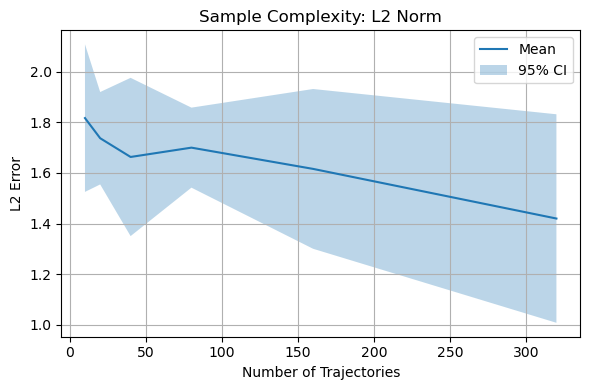

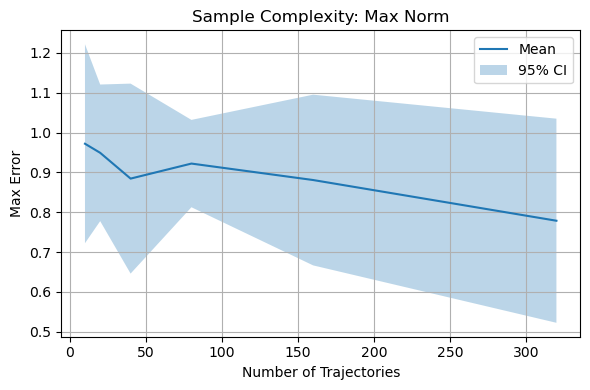

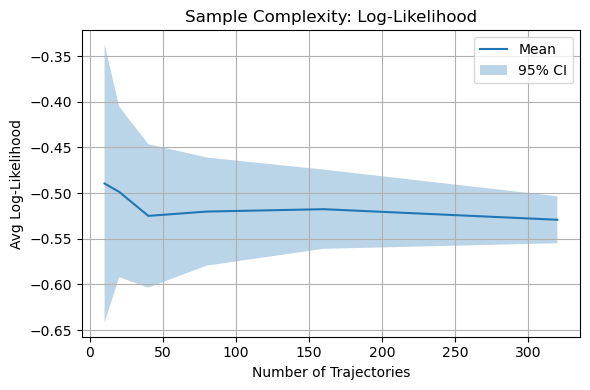

In [125]:
plot_with_ci(traj_sizes, l2s, "L2 Error", "Sample Complexity: L2 Norm")
plot_with_ci(traj_sizes, maxs, "Max Error", "Sample Complexity: Max Norm")
plot_with_ci(traj_sizes, lls, "Avg Log-Likelihood", "Sample Complexity: Log-Likelihood")